## Random Forest Modelling

### Import relevant libraries and dataset

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.metrics import RocCurveDisplay, roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids

from joblib import dump, load

In [4]:
df = pd.read_csv('../../Data/processed/weatherAUS_imputed.csv')
df.head()

,Date,Location,Year,Month,RainToday,RainTomorrow,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindGustDir_angle,Latitude,Longitude,Cloud,Pressure,Temperature,Humidity,temp_fluctuation
0,2009-01-01,Cobar,2009,1,0.0,0.0,-0.254034,1.452543,1.231645,0.544048,0.367568,-0.016581,0.134517,-0.346762,-1.566909,1.483789,-2.239319,1.266185
1,2009-01-02,Cobar,2009,1,0.0,0.0,-0.254034,2.092290,1.417426,-0.274399,0.142577,-0.016581,0.134517,-1.337620,-0.534263,0.523016,-2.103988,-0.123978
2,2009-01-03,Cobar,2009,1,0.0,0.0,-0.254034,1.589632,1.497046,-0.795229,-0.307405,-0.016581,0.134517,-1.337620,-0.664246,1.892307,-2.753579,1.531952
3,2009-01-04,Cobar,2009,1,0.0,0.0,-0.254034,1.178365,0.780464,0.395239,-1.432358,-0.016581,0.134517,-0.346762,-0.787008,1.756134,-1.400263,1.450178
4,2009-01-05,Cobar,2009,1,0.0,0.0,-0.254034,1.315454,1.205105,-0.720824,1.267530,-0.016581,0.134517,-0.544934,-0.765344,1.839351,-1.535595,1.102637


In [5]:
#Before starting our modelling, we will define a ROC curve function to dipslay the results 
def roc_curve_custom(model, X, y):
    y_score = model.predict_proba(X)[:, 1] 
    fpr, tpr, _ = roc_curve(y, y_score)
    roc_auc = auc(fpr, tpr)
    
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='model')
    roc_display.plot(color='orange', label=f'clf model (auc = {np.round(roc_auc,2)})')
    plt.grid(True)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--',label='Random (auc = 0.5)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

In [6]:
#We will also define a function to display the confusion matrix and classification_report 
def confusion_matrix_classification_report(test, pred_test, train, pred_train):
    #calculate confusion matrix 
    conf_matrix = confusion_matrix(test, pred_test)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)  # Adjust font scale if needed
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, square=True)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Confusion Matrix')
    plt.show()

    # Generate classification report
    report = classification_report(test, pred_test)

    # Print the classification report
    print('-------------------------')
    print(report)

    # Calculate accuracy for both sets
    print('-------------------------')
    train_accuracy = accuracy_score(train, pred_train)
    test_accuracy = accuracy_score(test, pred_test)
    print("Accuracy Train Set:", np.round(train_accuracy,3), "Accuracy Test Set:", np.round(test_accuracy,3))

### Random Forest

### 1. Without over or undersampling 

In [7]:
data = df.drop(columns=['RainTomorrow', 'Location', 'Date'])
target = df['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

### 1.1  Default Random Forest model

In [8]:
#default parameters: n_estimators=100, *, criterion='gini', max_depth=None
rdf = RandomForestClassifier(n_jobs=-1, random_state=321)
rdf.fit(X_train,y_train)

RandomForestClassifier(n_jobs=-1, random_state=321)

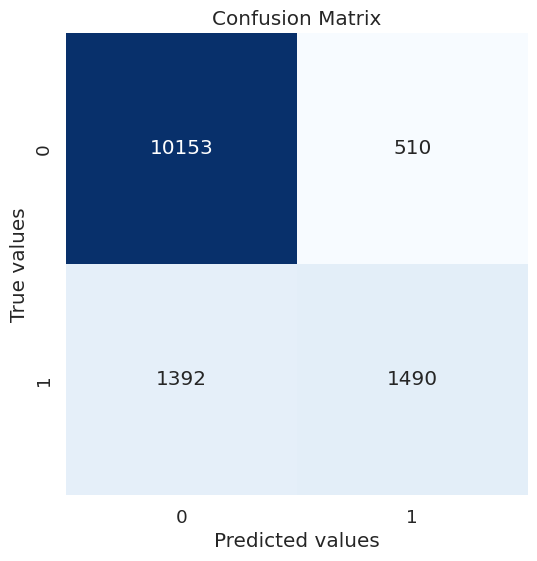

-------------------------
              precision    recall  f1-score   support

         0.0       0.88      0.95      0.91     10663
         1.0       0.74      0.52      0.61      2882

    accuracy                           0.86     13545
   macro avg       0.81      0.73      0.76     13545
weighted avg       0.85      0.86      0.85     13545

-------------------------
Accuracy Train Set: 1.0 Accuracy Test Set: 0.86


In [9]:
y_pred_test = rdf.predict(X_test)
y_pred_train = rdf.predict(X_train)
confusion_matrix_classification_report(y_test, y_pred_test, y_train, y_pred_train)

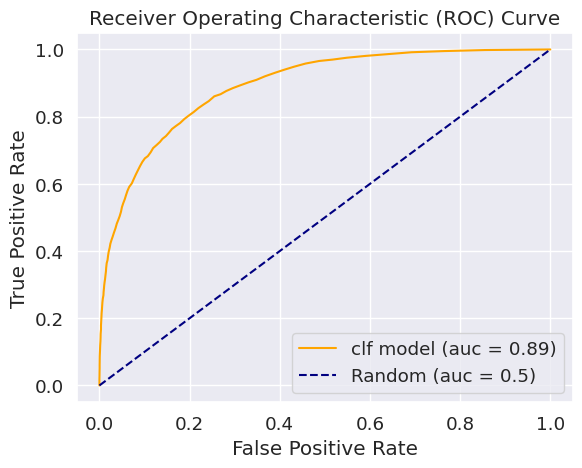

In [10]:
roc_curve_custom(rdf, X_test, y_test)

AUC Value: An AUC value ranges from 0 to 1, where:

AUC = 1 implies a perfect classifier that perfectly separates positive and negative instances.
AUC = 0.5 implies a classifier that performs as good as random guessing.
AUC < 0.5 implies a classifier that performs worse than random guessing.

0.89 AUC: An AUC of 0.89 suggests that the model performs well across a wide range of thresholds. 

The model performs quite well for class 0, with high precision, recall, and F1-score, indicating that it's good at correctly identifying instances of class 0.

However, for class 1, the model's performance is relatively lower, especially in terms of recall (52%). This suggests that the model struggles more to correctly identify instances of class 1,which is likely linked to the imbalance in the dataset or a challenge in distinguishing class 1 instances from others.

The overall accuracy of the model is 86%, which is the proportion of correctly classified instances out of the total instances.

Let's do some hyperparameters tuning for better results.

### 1.2 GridSearch

In [27]:
param_grid = {
    'criterion': ['gini', 'entropy'], # Split criterion
    'n_estimators': [50, 150, 200],   # Number of trees in the forest
    'max_depth': [10, 20, 30],        # Maximum depth of the tree
    'min_samples_split': [3, 5],      # Minimum number of samples required to split an internal node
    'min_samples_leaf': [2, 4]        # Minimum number of samples required to be at a leaf node
}
nfolds=3

In [28]:
grid_rdf = GridSearchCV(rdf, param_grid, cv=nfolds)

In [29]:
rdf_fit = grid_rdf.fit(X_train, y_train)

In [30]:
dump(rdf_fit, 'rdf_fit.joblib')

['rdf_fit.joblib']

In [31]:
rdf_fit = load('rdf_fit.joblib')
rdf_fit.best_params_

{'criterion': 'entropy',
 'max_depth': 20,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 150}

### 1.3 Model with best parameters

In [10]:
rdf_best = RandomForestClassifier(n_jobs=-1, 
                                  criterion = 'entropy',
                                  max_depth = 20,
                                  min_samples_leaf = 2,
                                  min_samples_split = 5,
                                  n_estimators = 150,
                                  random_state=321)
rdf_best.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', max_depth=20, min_samples_leaf=2,
                       min_samples_split=5, n_estimators=150, n_jobs=-1,
                       random_state=321)

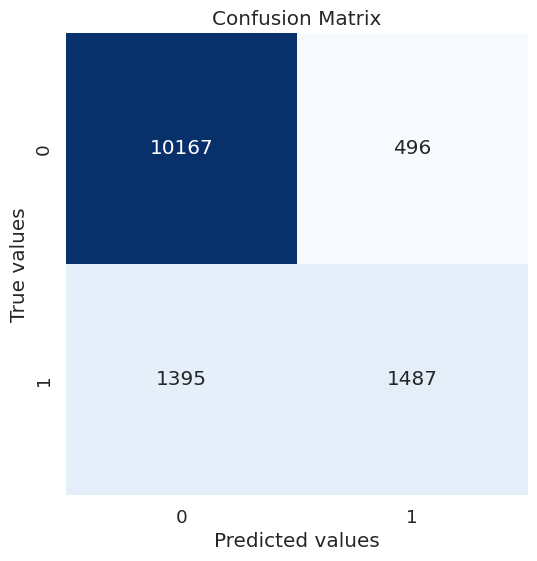

-------------------------
              precision    recall  f1-score   support

         0.0       0.88      0.95      0.91     10663
         1.0       0.75      0.52      0.61      2882

    accuracy                           0.86     13545
   macro avg       0.81      0.73      0.76     13545
weighted avg       0.85      0.86      0.85     13545

-------------------------
Accuracy Train Set: 0.98 Accuracy Test Set: 0.86


In [11]:
y_pred_test_best = rdf_best.predict(X_test)
y_pred_train_best = rdf_best.predict(X_train)

confusion_matrix_classification_report(y_test, y_pred_test_best, y_train, y_pred_train_best)

### 2. Oversampling

### 2.1 Random Oversampling

In [11]:
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X_train,y_train)

In [12]:
rfc_ros = RandomForestClassifier(n_jobs=-1, random_state=321)
rfc_ros.fit(X_ros,y_ros)

RandomForestClassifier(n_jobs=-1, random_state=321)

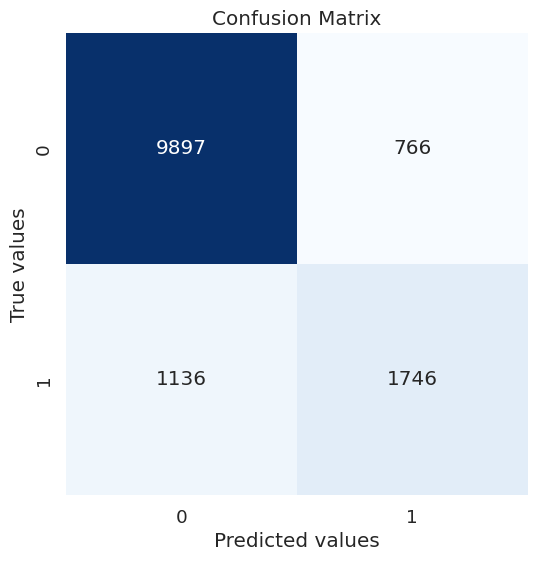

-------------------------
              precision    recall  f1-score   support

         0.0       0.90      0.93      0.91     10663
         1.0       0.70      0.61      0.65      2882

    accuracy                           0.86     13545
   macro avg       0.80      0.77      0.78     13545
weighted avg       0.85      0.86      0.86     13545

-------------------------
Accuracy Train Set: 1.0 Accuracy Test Set: 0.86


In [13]:
y_pred_ros = rfc_ros.predict(X_test)
y_pred_train = rfc_ros.predict(X_train)

confusion_matrix_classification_report(y_test, y_pred_ros, y_train, y_pred_train)

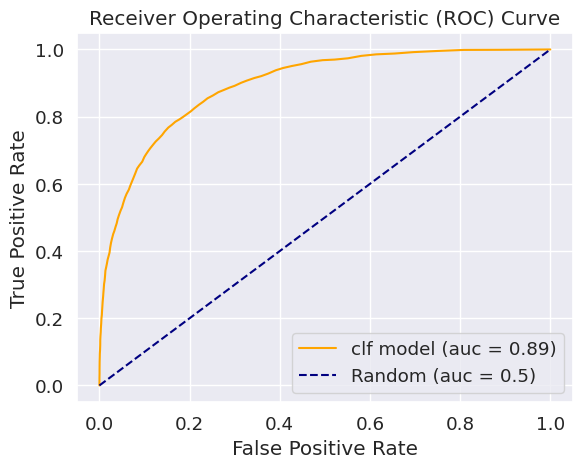

In [14]:
roc_curve_custom(rfc_ros, X_test, y_test)

### 2.2 SMOTE 

In [87]:
smo = SMOTE()
X_sm, y_sm = smo.fit_resample(X_train,y_train)

In [88]:
rfc_sm = RandomForestClassifier(n_jobs=-1, random_state=321)
rfc_sm.fit(X_sm,y_sm)

RandomForestClassifier(n_jobs=-1, random_state=321)

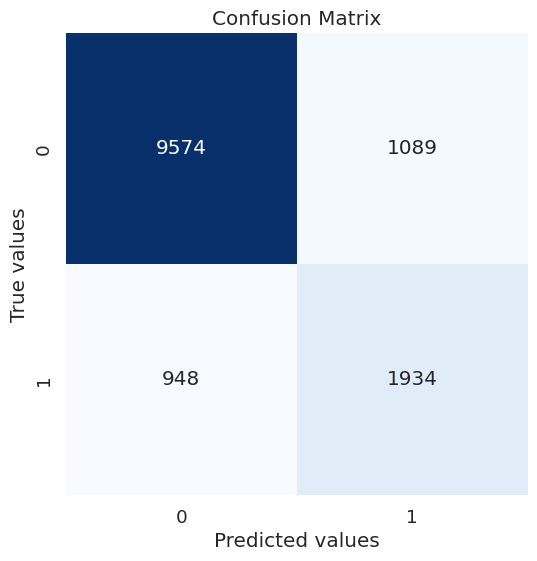

-------------------------
              precision    recall  f1-score   support

         0.0       0.91      0.90      0.90     10663
         1.0       0.64      0.67      0.66      2882

    accuracy                           0.85     13545
   macro avg       0.77      0.78      0.78     13545
weighted avg       0.85      0.85      0.85     13545

-------------------------
Accuracy Train Set: 1.0 Accuracy Test Set: 0.85


In [89]:
y_pred_sm = rfc_sm.predict(X_test)
y_pred_train_sm = rfc_sm.predict(X_train)

confusion_matrix_classification_report(y_test, y_pred_sm, y_train, y_pred_train_sm)

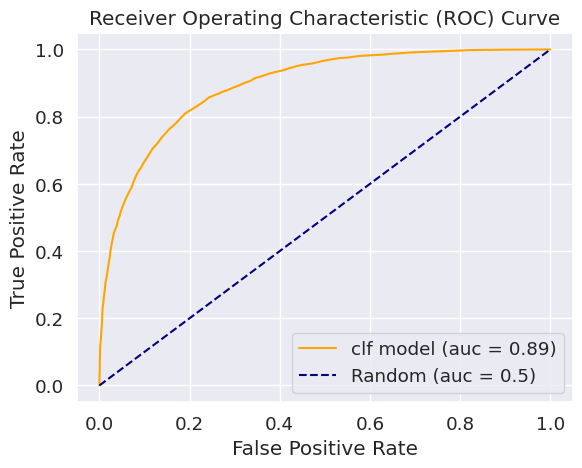

In [90]:
roc_curve_custom(rfc_sm, X_test, y_test)

### 3. Undersampling

### 3.1 Random Undersampling

In [15]:
rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_resample(X_train,y_train)

In [16]:
rfc_rus = RandomForestClassifier(n_jobs=-1, random_state=321)
rfc_rus.fit(X_rus,y_rus)

RandomForestClassifier(n_jobs=-1, random_state=321)

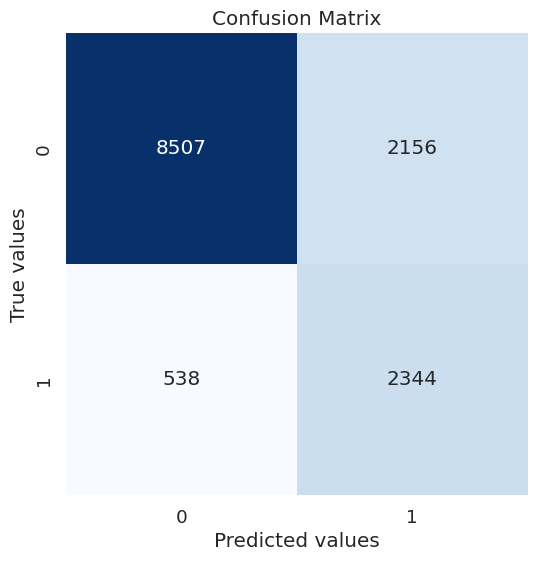

-------------------------
              precision    recall  f1-score   support

         0.0       0.94      0.80      0.86     10663
         1.0       0.52      0.81      0.64      2882

    accuracy                           0.80     13545
   macro avg       0.73      0.81      0.75     13545
weighted avg       0.85      0.80      0.81     13545

-------------------------
Accuracy Train Set: 0.885 Accuracy Test Set: 0.801


In [17]:
y_pred_rus= rfc_rus.predict(X_test)
y_pred_train_rus = rfc_rus.predict(X_train)
conf_matrix = confusion_matrix(y_test, y_pred_rus)

confusion_matrix_classification_report(y_test, y_pred_rus, y_train, y_pred_train_rus)

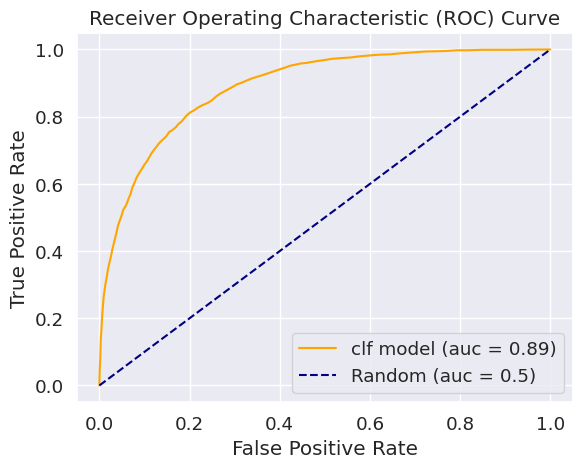

In [18]:
roc_curve_custom(rfc_rus, X_test, y_test)

### 4. Conclusion Over/Undersampling

SMOTE and Random Oversampling are quite similar in terms of performance. For Random Oversampling the precision for class 1 is better than the precision for class 1 of SMOTE (0.69 vs. 0.64) but the recall score of class 1 is better for SMOTE (0.67 vs. 0.61)

However the accuracy of the model using random oversampling is slighly better. So let's continue our analysis with Random Oversampling.

### 5. RandomOverSampler Hyperparameter Tuning 

### 5.1 GridSearchCV

In [99]:
clf_rf = RandomForestClassifier(random_state=321)

param_grid = {
    'criterion': ['entropy'],         # Split criterion
    'n_estimators': [150, 200],       # Number of trees in the forest
    'max_depth': [10, 20, 30],        # Maximum depth of the tree
    'min_samples_split': [3, 5],      # Minimum number of samples required to split an internal node
    'min_samples_leaf': [2, 4],       # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt']
}

grid_cv_ros = GridSearchCV(clf_rf, param_grid, cv=3, refit=True)

In [100]:
rdf_ros_fit1 = grid_cv_ros.fit(X_ros, y_ros)

In [101]:
dump(rdf_ros_fit1, 'rdf_ros_fit1.joblib')

['rdf_ros_fit1.joblib']

In [6]:
rdf_ros_fit1 = load('rdf_ros_fit1.joblib')
rdf_ros_fit1.best_params_

{'criterion': 'entropy',
 'max_depth': 30,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 3,
 'n_estimators': 200}

In [103]:
params = {
    'criterion': ['entropy'],       
    'n_estimators': [500, 1000], 
    'max_features': ['sqrt']
}
grid_cv_ros2 = GridSearchCV(clf_rf, params, cv=3, refit=True)

In [104]:
rdf_ros_fit2 = grid_cv_ros2.fit(X_ros, y_ros)

In [105]:
dump(rdf_ros_fit2, 'rdf_ros_fit2.joblib')

['rdf_ros_fit2.joblib']

In [7]:
rdf_ros_fit2 = load('rdf_ros_fit2.joblib')
rdf_ros_fit2.best_params_

{'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 1000}

### 5.2 Best Parameter Fit

In [11]:
clf = RandomForestClassifier(n_jobs=-1,criterion='entropy', max_features='sqrt', n_estimators=1000,random_state=321)
rfc_ros_best = clf.fit(X_ros,y_ros)

In [24]:
dump(rfc_ros_best, 'rfc_ros_best.joblib')

['rfc_ros_best.joblib']

In [14]:
rfc_ros_best = load('rfc_ros_best.joblib')

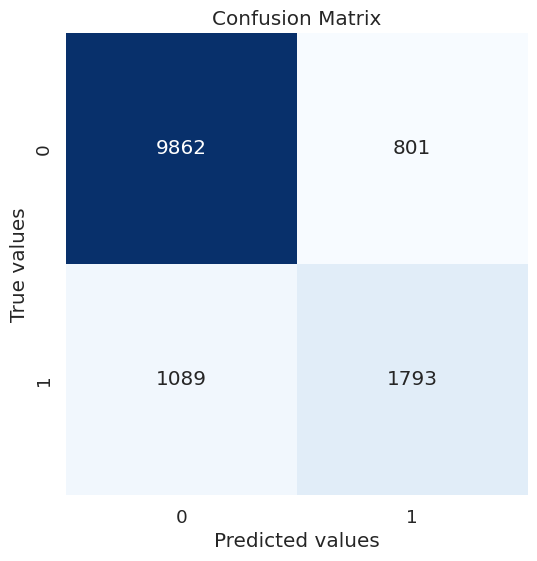

-------------------------
              precision    recall  f1-score   support

         0.0       0.90      0.92      0.91     10663
         1.0       0.69      0.62      0.65      2882

    accuracy                           0.86     13545
   macro avg       0.80      0.77      0.78     13545
weighted avg       0.86      0.86      0.86     13545

-------------------------
Accuracy Train Set: 1.0 Accuracy Test Set: 0.86


In [15]:
y_pred_ros_best = rfc_ros_best.predict(X_test)
y_pred_train_ros_best = rfc_ros_best.predict(X_train)

confusion_matrix_classification_report(y_test, y_pred_ros_best, y_train, y_pred_train_ros_best)

Hyperparameter tuning didn't lead to a better result.

### 6. Boosting

In [16]:
ac = AdaBoostClassifier(base_estimator=rfc_ros_best)
ac.fit(X_ros,y_ros)

AdaBoostClassifier(base_estimator=RandomForestClassifier(criterion='entropy',
                                                         n_estimators=1000,
                                                         n_jobs=-1,
                                                         random_state=321))

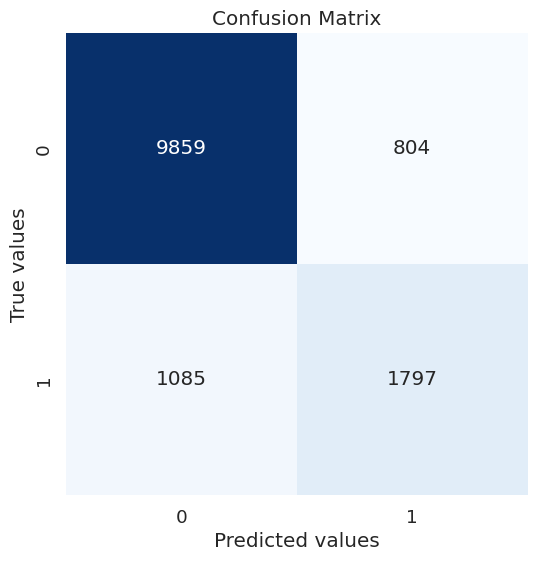

-------------------------
              precision    recall  f1-score   support

         0.0       0.90      0.92      0.91     10663
         1.0       0.69      0.62      0.66      2882

    accuracy                           0.86     13545
   macro avg       0.80      0.77      0.78     13545
weighted avg       0.86      0.86      0.86     13545

-------------------------
Accuracy Train Set: 1.0 Accuracy Test Set: 0.861


In [17]:
y_pred_ac = ac.predict(X_test)
y_pred_train_ac = ac.predict(X_train)

confusion_matrix_classification_report(y_test, y_pred_ac, y_train, y_pred_train_ac)

Adaptive Boosting did not lead to any better results either. 

### 7. Cross Validation

In [ ]:
# Define custom scoring metrics
scoring = {
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1_score': make_scorer(f1_score, average='weighted')
}

#We take the best performing model with random oversampling to compute the cross validation results
cv_results = cross_validate(rfc_ros, X_train, y_train, cv=10, return_estimator=True, scoring=scoring)

In [12]:
dump(cv_results, 'cv_rdf_ros.joblib')

['cv_rdf_ros.joblib']

In [13]:
cv_results = load('cv_rdf_ros.joblib')

In [14]:
from tabulate import tabulate
fold_numbers = range(1,11)
test_precision = cv_results['test_precision']
test_recall = cv_results['test_recall']
test_f1_score = cv_results['test_f1_score']
table = [["Fold", "Test Precision", "Test Recall", "Test F1-Score"]]
for fold, prec, recall, f1 in zip(fold_numbers, test_precision, test_recall, test_f1_score):
    table.append([fold, f"{prec:.3f}", f"{recall:.3f}", f"{f1:.3f}"])

# Print table
print(tabulate(table, headers="firstrow", tablefmt="pretty"))

+------+----------------+-------------+---------------+
| Fold | Test Precision | Test Recall | Test F1-Score |
+------+----------------+-------------+---------------+
|  1   |     0.858      |    0.865    |     0.856     |
|  2   |     0.855      |    0.863    |     0.852     |
|  3   |     0.850      |    0.858    |     0.846     |
|  4   |     0.848      |    0.857    |     0.846     |
|  5   |     0.855      |    0.863    |     0.852     |
|  6   |     0.848      |    0.857    |     0.847     |
|  7   |     0.852      |    0.860    |     0.851     |
|  8   |     0.847      |    0.856    |     0.847     |
|  9   |     0.857      |    0.864    |     0.855     |
|  10  |     0.856      |    0.864    |     0.854     |
+------+----------------+-------------+---------------+


### 8. Feature Importance

Now that we figured out the best fitting model, let's have a look at the feature importance 

Feature ranking:
1. feature 5 (0.172664) - Sunshine
2. feature 13 (0.128890) - Humidity
3. feature 11 (0.095977) - Pressure
4. feature 14 (0.086468) - temp_fluctuation
5. feature 10 (0.083754) - Cloud
6. feature 6 (0.076133) - WindGustSpeed
7. feature 12 (0.060925) - Temperature
8. feature 4 (0.051692) - Evaporation
9. feature 3 (0.049258) - Rainfall
10. feature 7 (0.039446) - WindGustDir_angle
11. feature 9 (0.036431) - Longitude
12. feature 8 (0.034334) - Latitude
13. feature 1 (0.032713) - Month
14. feature 0 (0.030491) - Year
15. feature 2 (0.020822) - RainToday


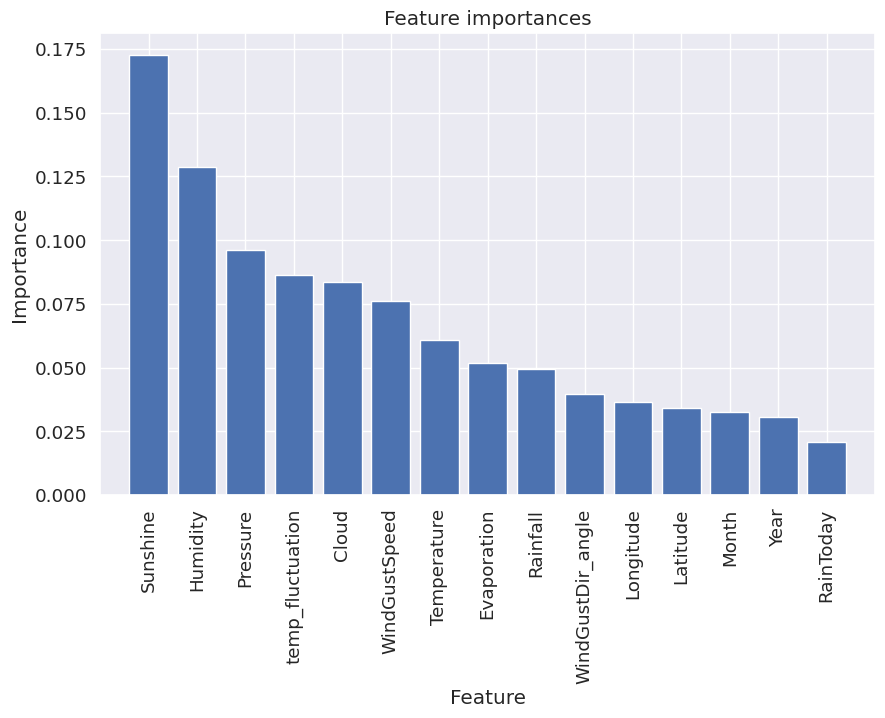

In [16]:
column_names= data.columns 
importances = rfc_ros.feature_importances_

# Get indices of features sorted by importance
indices = np.argsort(importances)[::-1]

# Print feature ranking
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print("%d. feature %d (%f) - %s" % (f + 1, indices[f], importances[indices[f]], column_names[indices[f]]))

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], color="b", align="center")
plt.xticks(range(X_train.shape[1]), [column_names[i] for i in indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

### 9. Conclusion 